DATA COLLECTION AND PREPROCESSING

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 1 1 0 1 0 2 0 1 0 1 0 1 1 1 0 0 1 0 1 2 1 0 1 1 0 1 1]


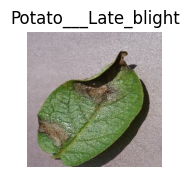

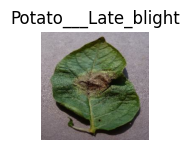

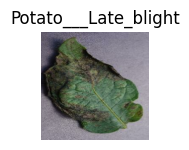

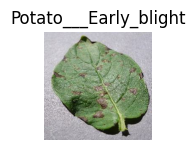

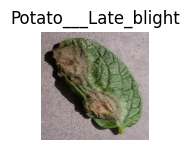

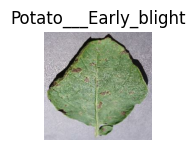

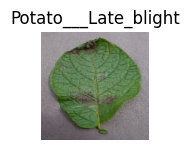

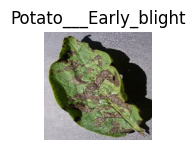

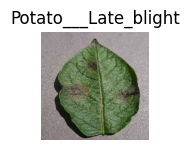

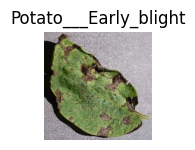

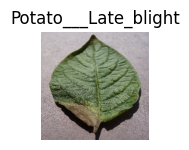

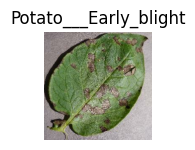

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [7]:
plt.figure(figsize=(8,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        image = image_batch[i].numpy().astype(np.uint8)
        plt.imshow(image)
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        plt.show()
plt.tight_layout

80% ==> training
20% ==> 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
train_ds = dataset.skip(54)
len(train_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = train_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf( ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle :
        ds.shuffle(shuffle_size, seed = 12)
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

MODEL BUILDING

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)



In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/60
54/54 [==============================] - 141s 2s/step - loss: 0.9131 - accuracy: 0.4832 - val_loss: 0.8840 - val_accuracy: 0.7083
Epoch 2/60
54/54 [==============================] - 98s 2s/step - loss: 0.7165 - accuracy: 0.6725 - val_loss: 0.6896 - val_accuracy: 0.7188
Epoch 3/60
54/54 [==============================] - 101s 2s/step - loss: 0.5334 - accuracy: 0.7656 - val_loss: 0.5119 - val_accuracy: 0.7396
Epoch 4/60
54/54 [==============================] - 99s 2s/step - loss: 0.3557 - accuracy: 0.8524 - val_loss: 0.2665 - val_accuracy: 0.8802
Epoch 5/60
54/54 [==============================] - 90s 2s/step - loss: 0.3075 - accuracy: 0.8773 - val_loss: 0.2489 - val_accuracy: 0.8802
Epoch 6/60
54/54 [==============================] - 99s 2s/step - loss: 0.2866 - accuracy: 0.8854 - val_loss: 0.2257 - val_accuracy: 0.9115
Epoch 7/60
54/54 [==============================] - 88s 2s/step - loss: 0.2000 - accuracy: 0.9219 - val_loss: 0.3126 - val_accuracy: 0.8698
Epoch 8/60
54/54 [

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 329ms/step - loss: 0.0437 - accuracy: 0.9828


In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

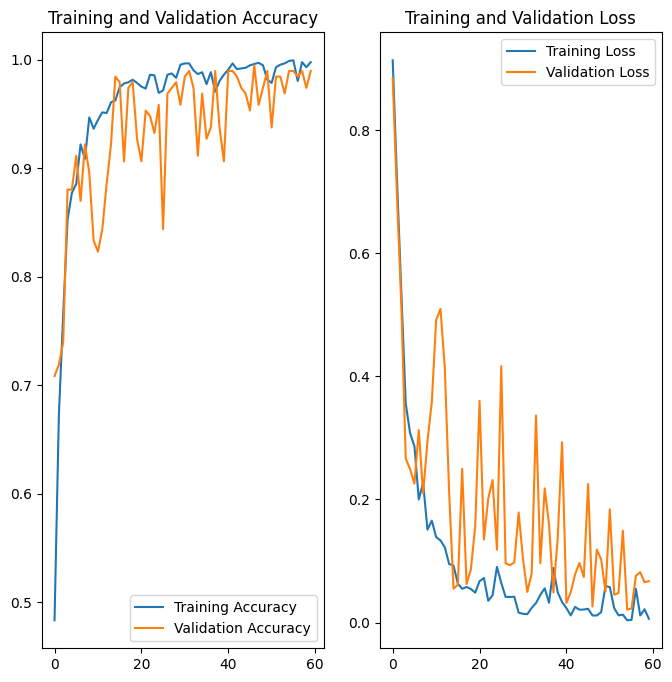

In [31]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()


First Image To Predict
Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 487ms/step
Predicted Label :  Potato___Early_blight


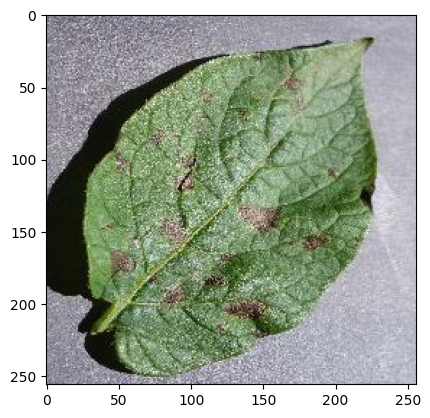

In [32]:
import numpy as np

for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype(np.uint8)
    first_label = labels_batch[0].numpy()

    print("First Image To Predict")
    plt.imshow(first_image)
    print("Actual Label : ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label : ", class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):

  # Preprocess the image
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.cast(img_array, tf.float32)  # Cast to float32 (common practice)
  img_array = tf.expand_dims(img_array, 0)

  # Make prediction and get the most likely class
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]

  # Calculate and round confidence
  confidence = round(100 * np.max(predictions[0]), 2)

  return predicted_class, confidence


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
for images, labels in test_ds.take(1):
    
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.axis("off")
        image = images[i].numpy().astype(np.uint8)
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}, \n Confidence : {confidence}%")
        plt.imshow(image)
        plt.show()
        


NameError: name 'test_ds' is not defined

<Figure size 1500x1500 with 0 Axes>

In [36]:
import os
model_version = max([int(i) for i in os.listdir("../Models") + [0]]) + 1
model.save(f"../Models/{model_version}")

INFO:tensorflow:Assets written to: ../Models/1\assets


INFO:tensorflow:Assets written to: ../Models/1\assets
